# Séance 2 - Réseau de neurones convolutionnel

On se propose de classifier les chiffres manuscrit du dataset [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) en définissant ses propres réseaux de neurones convolutionnel. L'objectif est de découvrir la manière d'entraîner ces algorithmes et observer en pratique les bases théoriques discutées en cours.

## Exploration des données

Commençons par importer les données.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

(X_train_full, y_train_full), (X_test, y_test) = (keras.datasets.fashion_mnist.load_data())

**Consigne** : À l'aide de la fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), séparer le jeu d'entraînement complet en un dataset d'entraînement et un dataset de validation. Afficher les tailles des datasets respectifs.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

for (dataset, name) in zip([X_train, X_valid, X_test], ["Train", "Validation", "Test"]):
  print(name, ":", dataset.shape)

Train : (48000, 28, 28)
Validation : (12000, 28, 28)
Test : (10000, 28, 28)


Les classes sont encore des nombres, mais ils correspondent à une catégorie. Pour mieux visualiser, nous allons faire un dictionnaire.

In [3]:
label_map = {0: "t-shirt/top", 1: "trouser", 2: "pullover",
             3: "dress", 4: "coat", 5: "sandal",
             6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}

**Consigne** : Afficher plusieurs images du dataset d'entraînement aléatoirement. On pourra utiliser la fonction [`imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) et le dictionnaire.

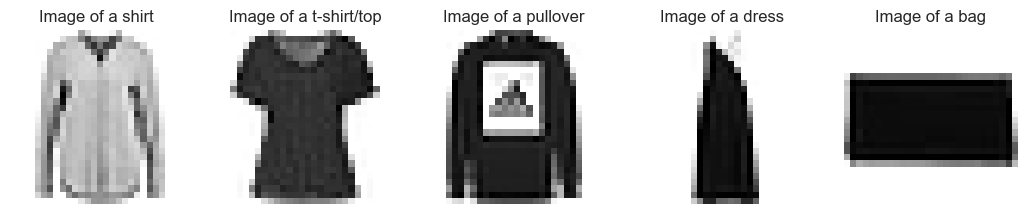

In [4]:
n = 5

plt.figure(figsize=(13, 6))
for plot_index in range(1, n+1):
  plt.subplot(1, n, plot_index)
  index = np.random.randint(low=0, high=len(X_train))
  plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
  plt.title("Image of a %s" % label_map[y_train[index]])
  plt.axis('off')
plt.show()

**Consigne** : Standardiser les données en utilisant la classe [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). On commencera par applatir les images en utilisant la méthode [`reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html), puis on applique le pré-processing et on termine par reformer la matrice.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

## Modélisation

On veut définir le réseau suivant:
* Deux convolutions avec 32 filtres 3x3 en conservant la taille. On utilisera la couche [`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)
* Une couche max pooling avec un filtre 2x2 et 2 de stride. On utilisera la couche [`MaxPool2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
* Une couche [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) puis un réseau dense de 64 neurones
* Une couche de sortie à 10 neurones

**Consigne** : Définir le réseau souhaité. On sélectionnera la fonction d'activation et la distribution initiale des poids adaptées.

In [6]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
])

2024-09-14 00:01:47.077410: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-14 00:01:47.077428: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-14 00:01:47.077433: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-14 00:01:47.077449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-14 00:01:47.077460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


**Consigne** : Calculer le nombre de paramètre du réseau de neurones à la main, puis vérifier avec la méthode [`summary`](https://keras.io/api/models/model/#summary-method).

Comptons le nombre de paramètres:
* Couche de convolution de 32 filtres 3x3 : 32 * (3x3x1 + 1) = 320, image de taille 28x28x32
* Couche de convolution de 32 filtres 3x3 : 32 * (3x3x32 + 1) = 9248, image de taille 28x28x32
* Couche de pooling : aucun paramètre, mais une taille de 14x14x32
* Couche dense de 64 neurones : 64 * (14x14x32 + 1) = 401472
* Couche dense de 10 neurones : 10 * (64 + 1) = 650

Soit au total un réseau de neurones avec 411690 paramètres.

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,690 (1.57 MB)

 Trainable params: 411,690 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

**Consigne** : Lancer l'entraînement avec les paramètres adaptés sur quelques époque pour vérifier son fonctionnement.

In [8]:
n_epochs = 5
learning_rate = 1e-3
batch_size = 32

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

Epoch 1/5


2024-09-14 00:01:47.332061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7161 - loss: 0.8436 - val_accuracy: 0.8347 - val_loss: 0.4593
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8460 - loss: 0.4285 - val_accuracy: 0.8593 - val_loss: 0.4037
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8672 - loss: 0.3755 - val_accuracy: 0.8703 - val_loss: 0.3716
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8796 - loss: 0.3395 - val_accuracy: 0.8739 - val_loss: 0.3571
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8826 - loss: 0.3267 - val_accuracy: 0.8795 - val_loss: 0.3375


## Couche BatchNormalization

On souhaite mesurer l'apport de la couche [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) à un réseau de neurone. Pour cela, on se propose de faire une étude comparative sur le modèle que nous venons de définir. Nous nous proposons de placer la couche BatchNormalization uniquement entre les deux couches de convolution.

**Consigne** : Définir une fonction `get_model` qui prend en paramètre:
* *normalization*: un booléen indiquant si la couche [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) doit être présente dans le modèle
* *learning_rate*: un flottant correspondant au learning rate souhaité

La fonction renvoie un modèle compilé.

In [9]:
def get_model(normalization=True, learning_rate=1e-4):
    if normalization:
        model = keras.models.Sequential([
            keras.layers.Input(shape=(28, 28, 1)),
            keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
            keras.layers.MaxPool2D(pool_size=2),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
            keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
        ])
    else:

        model = keras.models.Sequential([
            keras.layers.Input(shape=(28, 28, 1)),
            keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
            keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
            keras.layers.MaxPool2D(pool_size=2),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
            keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
        ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
    return model
    

**Consigne** : Combien de paramètre un modèle avec la couche de [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) a-t-il ? Est-ce équivalent à un modèle sans [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) ? 

In [10]:
model = get_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,818 (1.57 MB)

 Trainable params: 411,754 (1.57 MB)

 Non-trainable params: 64 (256.00 B)

Pour s'affranchir un peu de l'aléatoire, nous proposons de lancer trois fois les deux types de modèles pour les comparer.

**Consigne** : Écrire une boucle d'entraînement qui va stocker dans une liste les courbes d'apprentissage. Chaque élément de la liste correspondra à un dictionnaire avec pour clé:
* *type*: le type du réseau (avec ou sans BatchNormalization)
* *history*: l'historique d'apprentissage

In [11]:
n_epochs = 50
learning_rate = 1e-4
batch_size = 528
comparisons_number = 3
verbose = 0
results = []

for index in range(comparisons_number):
  print("Comparison %d :" % (index+1), end=" ")
  for normalization in [False, True]:
    network_type = "With normalization" if normalization else "Without normalization"
    print("%s..." % network_type, end= " ")
    model = get_model(normalization=normalization, learning_rate=learning_rate)
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=verbose)
    result = {"type": network_type, "history": pd.DataFrame(history.history)}
    results.append(result)
  print()

Comparison 1 : Without normalization... With normalization... 
Comparison 2 : Without normalization... With normalization... 
Comparison 3 : Without normalization... With normalization... 


Il faut maintenant visualiser les résultats. Commençons par préparer les données.

**Consigne** : Définir une fonction `agregate_result` qui prend en paramètre:
* *results*: le dictionnaire de résultat, au format décrit précédemment
* *network_type*: chaîne de caractère identifiant le type de réseau
* *metric_name*: le nom de la métrique d'intérêt

La fonction renverra deux matrices de tailles (nombre de comparaisons, nombre d'époque) : une pour le dataset d'entraînement et une pour le dataset de validation. On concatène donc les différentes courbes d'apprentissage.

In [12]:
def agregate_result(results, network_type, metric_name):
  training = np.zeros((comparisons_number, n_epochs))
  validation = np.zeros((comparisons_number, n_epochs))
  index = 0
  for result in results:
    if result["type"] == network_type:
      historic = result["history"]
      training[index] = historic[metric_name]
      validation[index] = historic["val_%s" % metric_name]
      index += 1
  return training, validation

**Consigne** : Visualiser les courbes d'apprentissage en faisant apparaître des intervals de confiance. On prendra exemple sur la fonction `show_results` du TP précédent. Commenter.

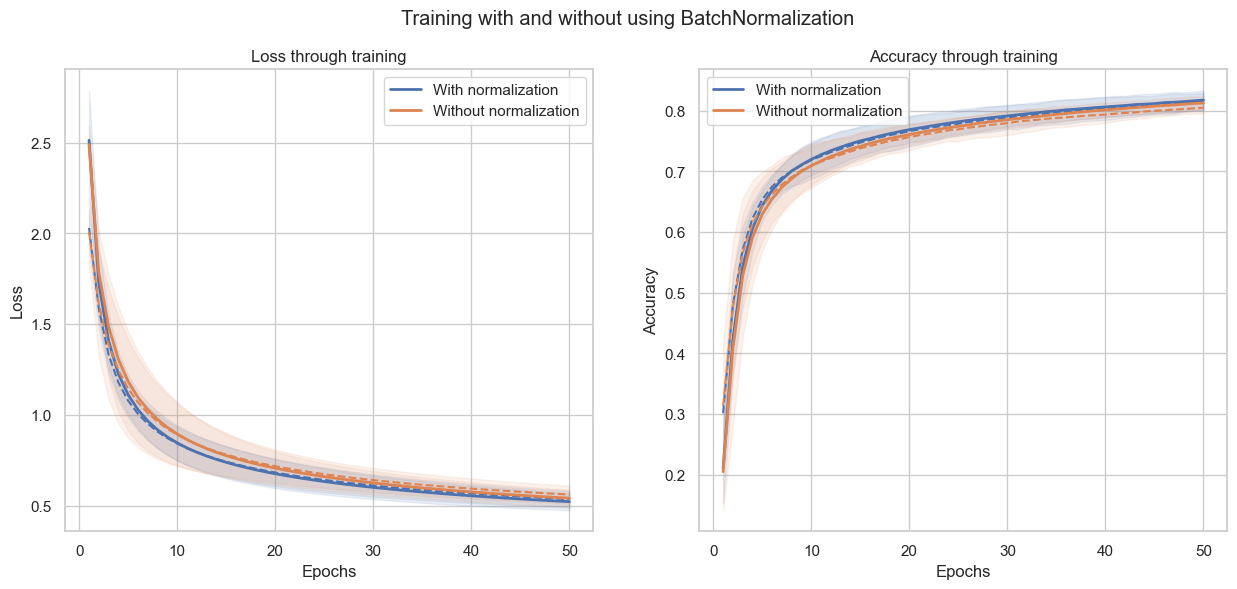

In [13]:
epochs = range(1, n_epochs+1)

figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))

for metric_name, axis in zip(["loss", "accuracy"], [axis_1, axis_2]):

  for index, network_type in enumerate(["With normalization", "Without normalization"]):
    color = sns.color_palette()[index]
    training, validation = agregate_result(results, network_type, metric_name)
    axis.plot(epochs, training.mean(axis=0), lw=2, label=network_type, color=color)
    axis.fill_between(epochs, training.mean(axis=0)-3*training.std(axis=0), training.mean(axis=0)+3*training.std(axis=0), color=color, alpha=0.1)
    axis.plot(epochs, validation.mean(axis=0), ls="--", color=color)
    axis.fill_between(epochs, validation.mean(axis=0)-3*validation.std(axis=0), validation.mean(axis=0)+3*validation.std(axis=0), color=color, alpha=0.1)

  axis.set_ylabel(metric_name.capitalize())
  axis.set_xlabel("Epochs")
  axis.set_title("%s through training" % metric_name.capitalize())
  axis.legend()


plt.suptitle("Training with and without using BatchNormalization")
plt.show()

Le simple ajout de cette couche permet de gagner en qualité d'entraînement. Si on obtient de meilleure performance métrique, on observe aussi une plus grande stabilité dans l'entraînement.

## Pour continuer

Choisir une ou plusieurs pistes de recherche parmi les suivantes. Il est possible de choisir une autre direction, mais elle doit être validé auparavant.

1. Nous avons utilisé la couche [`MaxPool2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/), mais on peut se poser la question de l'utilisation de la couche [`AveragePooling2D`](https://keras.io/api/layers/pooling_layers/average_pooling2d/) voire l'absence de couche de pooling.
2. Nous avons vu en cours qu'une agencement particulier de couches permet d'avoir les meilleurs performance pour la compétition ImageNet: les ResNet. Comment écrire un réseau résiduel à la main ?
3. Dans un [billet de blog](https://www.rpisoni.dev/posts/cossim-convolution/) est proposée une alternative à la couche convolutionnelle traditionnelle. On se propose de l'implémenter et d'explorer ses capacités.